Last chapter we implemented a [decision tree](../05_decision_tree/decision_tree.ipynb). Our decision tree performed slightly different than the `sklearn` decision tree. This is in part due to the difference between loss functions used by these models.

A loss function is a way to compare model predictions to actual values. That should sound familiar. We've been using accuracy to compare model predictions to actual values from the start. Loss functions are used during model training to _tell the model how it's doing_, allowing the learning algorithm to adjust the model accordingly and make it better.

We've used accuracy to train and benchmark our models but in practice accuracy is usually used as a benchmarking metric and not for training. There's nothing wrong with using accuracy as a loss function, especially with rule based models like what we've been working with, but as we move towards neural networks, more effective loss functions become possible.

We will implement a different loss function for our decision tree in this chapter, not because this new loss function is better, but because it's important to understand that there's nothing magical about the loss function _as long as it's informative for the model!_

## Loss so far

A brief refresh on how our loss function works. We construct a binary tree by repeatedly splitting the data on a feature value where all data points less than that value are in one branch and all data points greater than that value are in the other branch. The best feature value to split the data on is determined by the accuracy of the branches. If the accuracy of all the data points is better than the accuracy of the branches identified from the best feature value, then binary tree construction on that set of data points stops.

We've done all the hard work. Changing the loss function is easy, it's just a matter of swapping out accuracy for an alternative.

## Gini impurity

The Gini impurity is the typical loss function I've seen used by decision trees. In order to understand this loss function you need to understand probability. But you already understand probability.

### Probability {#sec-loss-probability}

Think back to our [baseline classifier](../02_baseline/baseline_classifier.ipynb) which always predicted the most common label in the training set. What is the accuracy of that model on the same training set? It is the ratio of the most common label over all labels. That happens to be the probability of the most common label.

At its core probability is asking the question, "how likely is event X going to happen?" It's commonly taught using simple scenarios because it's easy to grasp. Flip a coin. What's the chance it will be heads? 1/2. Roll a die. What's the chance it will be 2? 1/6. Play the lotto. What's the chance you will win? Very, very small.

That's all you need to know really and now we can implement the Gini impurity.

### How it works

We have a bunch of reviews. They have positive or negative labels. The Gini impurity is the probability of a positive label times the probability of _not_ a positive label plus the probability of a negative label times the probability of _not_ a negative label. That's a mouthful. Maybe we should start over and work up piece by piece with something more concrete.

Let's say 75% of the reviews are positive.

In [1]:
positive_prob = 0.75

The thing about probability is there is a 100% chance of some outcome. In our case the review must be positive or negative, so if 75% of the reviews are positive then the rest must be negative.

In [2]:
negative_prob = 1 - positive_prob
negative_prob

0.25

Now let's compute the Gini impurity using these numbers.

In [3]:
(
    positive_prob * (1 - positive_prob)
    + negative_prob * (1 - negative_prob)
)

0.375

[You may be asking why the Gini impurity is effectively `2 * positive_prob * negative_prob`. This is a side effect of how the generalized equation expands, but in practice it doesn't matter. Since 2 is a constant multiplier the relative order would be the same whether it's there or not.]{.aside}The first term is the probability of a positive label times the probability of not a positive label. The probability of not a positive label _is just the probability of a negative label!_ Why take this round about way of to say the probability of a positive label times the probability of a negative label?

Because it _generalizes_.

Let's imagine we have reviews with positive, negative, or neutral labels. Now the probability of not a positive label is the sum of negative and neutral label probabilities. What if we had 10 labels? Then the probability of not being a specific label would be the sum of the other 9 label probabilities. But it doesn't matter how many labels there are because the probability of not being a specific label is the same as the sum of all the other label probabilities. Subtracting the label probability from 1 is easy.

There's another wrinkle I didn't mention. The above definition is based on our use case of having two labels, but the actual definition extends to all labels. It sums up probability times it's opposite. In it's general form it's also quick to code.

In [4]:
def gini(probabilities):
    """Return the Gini impurity."""
    return sum(p * (1 - p) for p in probabilities)


gini([0.75, 0.25])

0.375

## Find the minimum

In machine learning it's common to minimize the loss. We can think of the loss value as a distance from the prediction to the actual label. A smaller loss means the prediction is closer to the actual label. This is the opposite of accuracy where higher is better.

To drive the point home, let's plot the Gini impurity and the accuracy for different probabilities and see what they look like.[A higher probability means more likely to get the correct label.]{.aside}

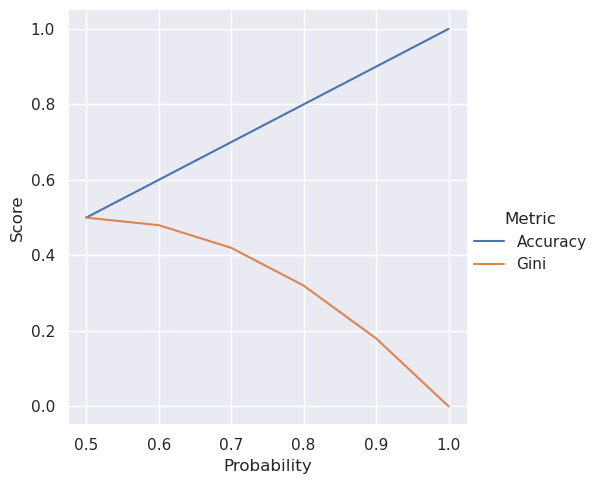

In [5]:
# | echo: false
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid")

data = []
for p in np.arange(0.5, 1.01, 0.1):
    data.append({"Probability": p, "Score": p, "Metric": "Accuracy"})
    data.append(
        {
            "Probability": p,
            "Score": gini([p, (1 - p)]),
            "Metric": "Gini",
        }
    )
sns.relplot(
    pd.DataFrame(data),
    x="Probability",
    y="Score",
    hue="Metric",
    kind="line",
)

We see the Gini impurity go down as the probability of predicting the correct label goes up, so a lower Gini impurity is better. The Gini impurity doesn't have a linear relationship with probability either, unlike accuracy.

## Putting it all together

Now it's just a matter of swapping the loss functions.

In [24]:
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.dummy import DummyClassifier
from sklearn.utils.multiclass import unique_labels


class Split(ClassifierMixin, BaseEstimator):
    """Split the data on the feature value."""

    def __init__(self, idx, value):
        # Index of the feature matrix.
        self.idx = idx
        # Value to split the data on.
        self.value = value

    def gini(self, X, y):
        """Return the average Gini impurity of the split."""
        # Convert other data types to numpy array
        # for consistency.
        X, y = np.array(X), np.array(y)

        # Get size of left and right hand side of split.
        N = len(X)
        N_rhs = (X[:, self.idx] >= self.value).sum()
        N_lhs = N - N_rhs
        # `DummyClassifier` has an attribute, `class_prior_`, which
        # contains the class probabilities after fitting. This is
        # the probability of each label in the training data!
        return (N_lhs / N) * gini(self.lhs_.class_prior_) + (
            N_rhs / N
        ) * gini(self.rhs_.class_prior_)

    def fit(self, X, y):
        # Convert other data types to numpy array
        # for consistency.
        X, y = np.array(X), np.array(y)

        # Grab class labels.
        self.classes_ = unique_labels(y)

        # Create boolean arrays to split the groups on.
        rhs = X[:, self.idx] >= self.value
        lhs = ~rhs

        # Create baseline classifiers for each split.
        self.lhs_ = DummyClassifier().fit(X[lhs], y[lhs])
        self.rhs_ = DummyClassifier().fit(X[rhs], y[rhs])

        return self

    def predict(self, X):
        # Convert other data types to numpy array
        # for consistency.
        X = np.array(X)

        # Make our empty prediction array.
        pred = np.zeros(X.shape[0], dtype=int)

        # Create boolean arrays to split the groups on.
        rhs = X[:, self.idx] >= self.value
        lhs = ~rhs

        # Populate the prediction array with predictions from
        # each group.
        if lhs.sum() > 0:
            pred[lhs] = self.lhs_.predict(X[lhs])
        if rhs.sum() > 0:
            pred[rhs] = self.rhs_.predict(X[rhs])

        return pred


def find_best_split(X, y):
    """Iterate over all possible values in `X` to find the best
    split point."""
    # Convert other data types to numpy array
    # for consistency.
    X, y = np.array(X), np.array(y)

    # Variables for the two groups.
    best_split = best_loss = None

    # Iterate over each feature.
    for i, column in enumerate(X.T):
        # Iterate over each unique value in column.
        for value in np.unique(column):
            try:
                split = Split(i, value).fit(X, y)
            except ValueError:
                # `DummyClassifier` will raise a `ValueError`
                # if it is trained on an empty dataset, in which
                # case we just skip this split.
                continue

            # Get the loss for this split.
            loss = split.gini(X, y)

            # Keep this split if it has the best loss so far.
            if best_loss is None or loss < best_loss:
                best_split = split
                best_loss = loss

    # Raise an error if there is no way to split the data.
    if best_split is None:
        raise ValueError

    return best_split


def find_best_splits(X, y):
    """Generate a binary tree based on the data."""
    # Create a baseline classifier for the entire dataset.
    unsplit = DummyClassifier().fit(X, y)
    try:
        # Create a split on the dataset.
        split = find_best_split(X, y)
    except ValueError:
        # If it's impossible to split the dataset, return
        # the baseline classifier.
        return unsplit

    # If the baseline classifier performs better than the
    # split classifier, return the baseline classifier.
    if gini(unsplit.class_prior_) <= split.gini(X, y):
        return unsplit

    # Create boolean arrays for each subset of the data based
    # on the split value.
    rhs = X[:, split.idx] >= split.value
    lhs = ~rhs

    # Recursively update the left hand side classifier.
    split.lhs_ = find_best_splits(X[lhs], y[lhs])
    # Recursively update the right hand side classifier.
    split.rhs_ = find_best_splits(X[rhs], y[rhs])

    # Return the updated split.
    return split


class DecisionTree(ClassifierMixin, BaseEstimator):
    """Binary decision tree classifier."""

    def fit(self, X, y):
        # Convert sparse matrix to `numpy` matrix.
        if issparse(X):
            X = X.toarray()
        # Convert `X` and `y` to `numpy` arrays for consistency.
        X, y = np.array(X), np.array(y)

        # Grab the labels.
        self.classes_ = unique_labels(y)

        # Create the binary tree.
        self.tree_ = find_best_splits(X, y)

        return self

    def predict(self, X):
        # Convert sparse matrix to `numpy` matrix.
        if issparse(X):
            X = X.toarray()
        # Convert `X` to `numpy` array for consistency.
        X = np.array(X)
        # Return predictions from the binary decision tree.
        return self.tree_.predict(X)

If you followed along last chapter you'll see the code is almost identical. Now let's run it and see what happens.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nlpbook import get_train_test_data

# Grab the data and extract the features and labels.
train, test = get_train_test_data()
features = "review"
label = "label"
X, y = train[features], train[label]
X_test, y_test = test[features], test[label]

# Set up the pipeline.
boc = CountVectorizer(analyzer="char", lowercase=False)
pipeline = Pipeline([("boc", boc), ("decision_tree", DecisionTree())])

# Train and score
pipeline.fit(X, y)
pipeline.score(X_test, y_test)

0.5558087487283825

And voila! We get the same accuracy as the `sklearn` implementation.